In [ ]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier ,plot_tree, export_text


from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.pipeline import Pipeline


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.metrics import roc_curve, auc

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
df = pd.read_csv('LoanStats_securev1.csv')

/tmp/ipython-input-476782289.py:1: DtypeWarning: Columns (118,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('LoanStats_securev1.csv')


In [ ]:
# data exploration
print("Dataset shape: ", df.shape)
print("Column names: ", df.columns.tolist)
print("\mFirts 5 rows: ")
print(df.head())
print("\nData types: ")
print(df.dtypes)

Dataset shape:  (96779, 151)
Column names:  <bound method IndexOpsMixin.tolist of Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)>
\mFirts 5 rows: 
          id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  104046719        NaN      14000        14000            14000   36 months   
1  104048967        NaN       5000         5000             5000   36 months   
2  104028593        NaN       4600         4600             4600   36 months   
3  104046702        NaN      14000        14000            14000   60 months   
4  104280113        NaN      15000        

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3469341167.py:4: SyntaxWarning: invalid escape sequence '\m'
  print("\mFirts 5 rows: ")


In [ ]:
# (checking for missing values)
print("Missing values per column: ")
print(df.isnull().sum())

Missing values per column: 
id                           0
member_id                96779
loan_amnt                    0
funded_amnt                  0
funded_amnt_inv              0
                         ...  
settlement_status        96669
settlement_date          96669
settlement_amount        96669
settlement_percentage    96669
settlement_term          96669
Length: 151, dtype: int64


In [ ]:
# dropping completely empty columns
df = df.dropna(axis=1, how='all')
#removing missing columns
columns_to_drop = ['member_id', 'desc', 'url', 'deferral_term', 'hardship_amount'
, 'hardship_leangth', 'hardship_dpd', 'orig_projected_additional_accrued_interest'
, 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'settlement_amount'
, 'settlement_percentage', 'settlement_term', 'dept_settlement_flag_date'
,'settlement_date', 'next_pymnt_d']
#dropping columns with many missing values (over 80%)
missing_percent = df.isnull().mean()
highly_missing_columns = missing_percent[missing_percent > 0.8].index.tolist()
columns_to_drop.extend(highly_missing_columns)

In [ ]:
df.drop(columns = columns_to_drop, errors = 'ignore', inplace=True)

In [ ]:
#checking dataset shape after column deletion
print(f"Rows: {len(df)}")
print(f"Columns: {len(df.columns)}" )
print("Shape after dropping high-missing columns:", df.shape)

Rows: 96779
Columns: 110
Shape after dropping high-missing columns: (96779, 110)


In [ ]:
# filling missing values (numerical with median, categorial with mode)

#identifying categorial and numerical columns
numerical_columns  = df.select_dtypes(include=[np.number]).columns
categorial_columns = df.select_dtypes(include=['object']).columns

# filling numerical values
if len(numerical_columns) > 0:
    numerical_imputer = SimpleImputer(strategy='median')
    df[numerical_columns] = numerical_imputer.fit_transform(df[numerical_columns])

# filling categorial columns
if len(categorial_columns) > 0:
  categorial_imputer = SimpleImputer(strategy='most_frequent')
  df[categorial_columns] = categorial_imputer.fit_transform(df[categorial_columns])

print('Missing values after automatic filling:')
print(df.isnull().sum())

Missing values after automatic filling:
id                            0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
                             ..
total_bc_limit                0
total_il_high_credit_limit    0
hardship_flag                 0
disbursement_method           0
debt_settlement_flag          0
Length: 110, dtype: int64


In [ ]:
# taking a sample
SAMPLE_SIZE = 55000
df_sample = df.sample(n= min(SAMPLE_SIZE, len(df)), random_state=42)

In [ ]:
# detecting outliers with IQR

# columns with outliers

for column in df_sample.columns:
  if df_sample[column].dtype in ['int64', 'float64']:
    Q1, Q3 = df_sample[column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    outliers = ((df_sample[column] < (Q1 - 1.5 * IQR)) | (df_sample[column] > (Q3 + 1.5*IQR))).sum()

    if outliers > 0 :
      print(f"{column}: {outliers} outliers")

id: 98 outliers
loan_amnt: 852 outliers
funded_amnt: 852 outliers
funded_amnt_inv: 851 outliers
installment: 1822 outliers
annual_inc: 2581 outliers
dti: 326 outliers
delinq_2yrs: 11343 outliers
fico_range_low: 1304 outliers
fico_range_high: 1304 outliers
inq_last_6mths: 1581 outliers
mths_since_last_delinq: 23445 outliers
open_acc: 1479 outliers
pub_rec: 10824 outliers
revol_bal: 3389 outliers
total_acc: 1304 outliers
out_prncp: 473 outliers
out_prncp_inv: 472 outliers
total_pymnt: 3738 outliers
total_pymnt_inv: 3737 outliers
total_rec_prncp: 5441 outliers
total_rec_int: 2142 outliers
total_rec_late_fee: 943 outliers
recoveries: 260 outliers
collection_recovery_fee: 260 outliers
last_pymnt_amnt: 6915 outliers
last_fico_range_high: 2648 outliers
last_fico_range_low: 2648 outliers
collections_12_mths_ex_med: 1087 outliers
mths_since_last_major_derog: 15096 outliers
acc_now_delinq: 316 outliers
tot_coll_amt: 9231 outliers
tot_cur_bal: 1888 outliers
open_acc_6m: 4715 outliers
open_act_il:

In [ ]:
# handling outliers
#capping all outliers
for column in df_sample.columns:
  if df_sample[column].dtype in ['int64', 'float64']:
    Q1, Q3 = df_sample[column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q3 - 1.5 * IQR
    df_sample[column] = np.where(df_sample[column]< lower_bound, lower_bound, df_sample[column])
    df_sample[column] = np.where(df_sample[column]> upper_bound, upper_bound, df_sample[column])

print('Outliers after capping:')
print(df_sample.describe())

Outliers after capping:
                 id     loan_amnt   funded_amnt  funded_amnt_inv  \
count  5.500000e+04  55000.000000  55000.000000     55000.000000   
mean   9.872121e+07  14853.634545  14853.634545     14849.449091   
std    2.335479e+06   9338.662648   9338.662648      9336.009688   
min    9.508201e+07   1700.000000   1700.000000      1700.000000   
25%    9.675049e+07   7800.000000   7800.000000      7800.000000   
50%    9.796378e+07  12000.000000  12000.000000     12000.000000   
75%    1.000874e+08  20000.000000  20000.000000     20000.000000   
max    1.042801e+08  38300.000000  38300.000000     38300.000000   

        installment     annual_inc           dti  delinq_2yrs  fico_range_low  \
count  55000.000000   55000.000000  55000.000000      55000.0    55000.000000   
mean     448.112619   78078.434851     18.499768          0.0      696.334455   
std      274.016965   39440.655117      7.954335          0.0       30.729414   
min       67.055000   24075.021250     

In [ ]:
# encoding
print(f"Encoding categorial columns and there are {len(categorial_columns)} categorial columns")
for column in categorial_columns:
  le = LabelEncoder()
  df_sample[column] =  le.fit_transform(le.fit_transform(df_sample[column]))

  print(f"\n{column} mapping:")
  mapping = dict(zip(le.classes_, le.transform(le.classes_)))
  print(mapping)


Encoding categorial columns and there are 24 categorial columns

term mapping:
{np.int64(0): np.int64(0), np.int64(1): np.int64(1)}

int_rate mapping:
{np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6), np.int64(7): np.int64(7), np.int64(8): np.int64(8), np.int64(9): np.int64(9), np.int64(10): np.int64(10), np.int64(11): np.int64(11), np.int64(12): np.int64(12), np.int64(13): np.int64(13), np.int64(14): np.int64(14), np.int64(15): np.int64(15), np.int64(16): np.int64(16), np.int64(17): np.int64(17), np.int64(18): np.int64(18), np.int64(19): np.int64(19), np.int64(20): np.int64(20), np.int64(21): np.int64(21), np.int64(22): np.int64(22), np.int64(23): np.int64(23), np.int64(24): np.int64(24), np.int64(25): np.int64(25), np.int64(26): np.int64(26), np.int64(27): np.int64(27), np.int64(28): np.int64(28), np.int64(29): np.int64(29), np.int64(30): np.int64(30), 

In [ ]:
# normalization with standard scaler

scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(df_sample), columns = df_sample.columns)
print(f"Dataset shape after normalization: {scaled_data.shape}")

Dataset shape after normalization: (55000, 110)


<Axes: >

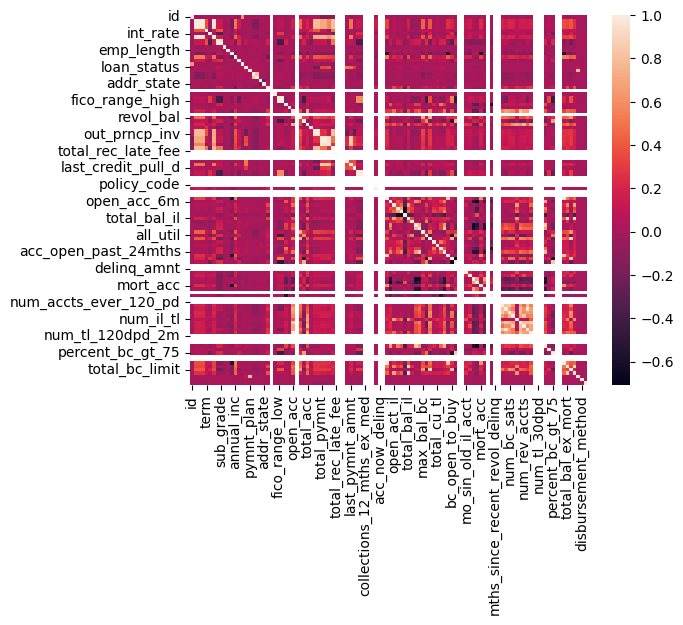

In [ ]:
# before applying PCA,checking what the data looks like with heatmap
sns.heatmap(scaled_data.corr())

In [ ]:
# dimensionality reduction(PCA)
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(pca_data)

#clean data frame
pca_df = pd.DataFrame(pca_data, columns = [f'PC{i+1}' for i in range(pca_data.shape[1])])

print(f"Dataset feature before PCA: {scaled_data.shape[1]}")
print(f"Dataset components after PCA: {pca_df.shape[1]}")
print(f"Kept variance: {pca.explained_variance_ratio_.sum()*100:.1f}%")
print(f"New shape: {pca_df.shape}")


Dataset feature before PCA: 110
Dataset components after PCA: 50
Kept variance: 95.3%
New shape: (55000, 50)


In [ ]:
# define x and y which can identify good and bad

df_raw = pd.read_csv("LoanStats_securev1.csv", low_memory=False)

good_statuses = ["Fully Paid", "Current", "In Grace Period"]

df_sup = df_sample.copy()
raw_status = df_raw.loc[df_sup.index, "loan_status"]

mask = raw_status.notna()
df_sup = df_sup.loc[mask].copy()
raw_status = raw_status.loc[mask]

df_sup["loan_good"] = raw_status.isin(good_statuses).astype(int)

explicit_leak_cols = ["loan_good", "loan_status", "id", "member_id"]

leakage_keywords = [
    "pymnt",
    "out_prncp",
    "recover",
    "total_rec",
    "total_pymnt",
    "settlement",
    "hardship",
    "last_fico",
    "last_credit_pull",
]

auto_leak_cols = [c for c in df_sup.columns if any(k in c for k in leakage_keywords)]
cols_to_drop = list(set(explicit_leak_cols + auto_leak_cols))

X = df_sup.drop(columns=cols_to_drop, errors="ignore")
y = df_sup["loan_good"]

In [ ]:
# train and test the data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Accuracy: 0.8825454545454545
              precision    recall  f1-score   support

         Bad       0.12      0.24      0.16       781
        Good       0.96      0.91      0.94     15719

    accuracy                           0.88     16500
   macro avg       0.54      0.58      0.55     16500
weighted avg       0.92      0.88      0.90     16500



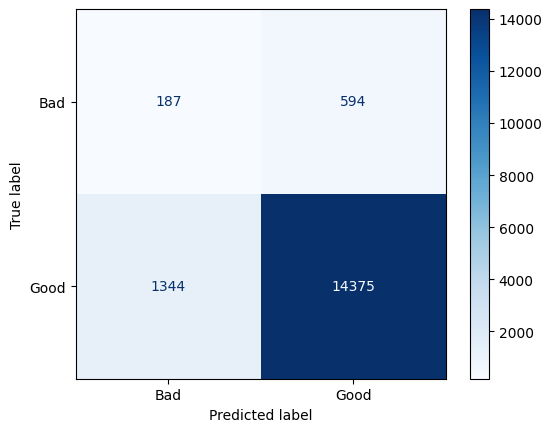

In [ ]:
#  XGBClassifier model

model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


#test Accuracy for model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Bad", "Good"]))


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Bad", "Good"])
disp.plot(cmap="Blues")
plt.show()

# Decision Tree Classifier

In [ ]:
#Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(criterion='entropy',max_depth=5,min_samples_split=50,min_samples_leaf=20,
                            class_weight='balanced',random_state=42)
#Train (Fit) the Model
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, min_samples_leaf=20, min_samples_split=50,
                       random_state=42)

In [ ]:
# Export the Decision Tree rules as text
tree_rules = export_text(dt, feature_names=list(X.columns))
print(tree_rules)

|--- sub_grade <= 14.50
|   |--- grade <= 1.50
|   |   |--- sub_grade <= 3.50
|   |   |   |--- revol_util <= 330.50
|   |   |   |   |--- bc_util <= 24.25
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- bc_util >  24.25
|   |   |   |   |   |--- class: 1
|   |   |   |--- revol_util >  330.50
|   |   |   |   |--- annual_inc <= 142500.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- annual_inc >  142500.00
|   |   |   |   |   |--- class: 1
|   |   |--- sub_grade >  3.50
|   |   |   |--- dti <= 12.32
|   |   |   |   |--- mo_sin_old_il_acct <= 135.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- mo_sin_old_il_acct >  135.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- dti >  12.32
|   |   |   |   |--- fico_range_high <= 671.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- fico_range_high >  671.50
|   |   |   |   |   |--- class: 1
|   |--- grade >  1.50
|   |   |--- inq_last_12m <= 0.50
|   |   |   |--- initial_list_status <= 0.50
|   |   |   |   |--- 

In [ ]:
# Decision Tree Classifier model accuracy and precision and recall
y_dt_proba=dt.predict(X_test)
prec_dt = precision_score(y_test, y_pred)
rec_dt = recall_score(y_test, y_pred)
f1_dt = f1_score(y_test, y_pred)
print(f"tree accuracy: {accuracy_score(y_test,y_dt_proba)}")
print(f"tree precision: {prec_dt}")
print(f"tree recall: {rec_dt}")

tree accuracy: 0.6493939393939394
tree precision: 0.9603179905137283
tree recall: 0.9144983777593995


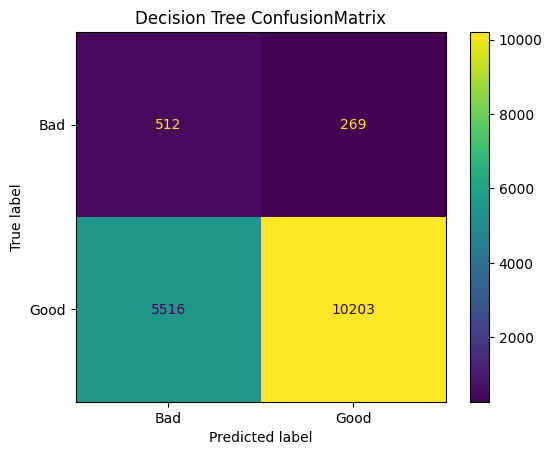

In [ ]:
#ConfusionMatrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_dt_proba, labels=[0, 1])
disp_dt = ConfusionMatrixDisplay(cm_dt, display_labels=["Bad", "Good"])
disp_dt.plot(values_format="d")
plt.title("Decision Tree ConfusionMatrix")
plt.show()

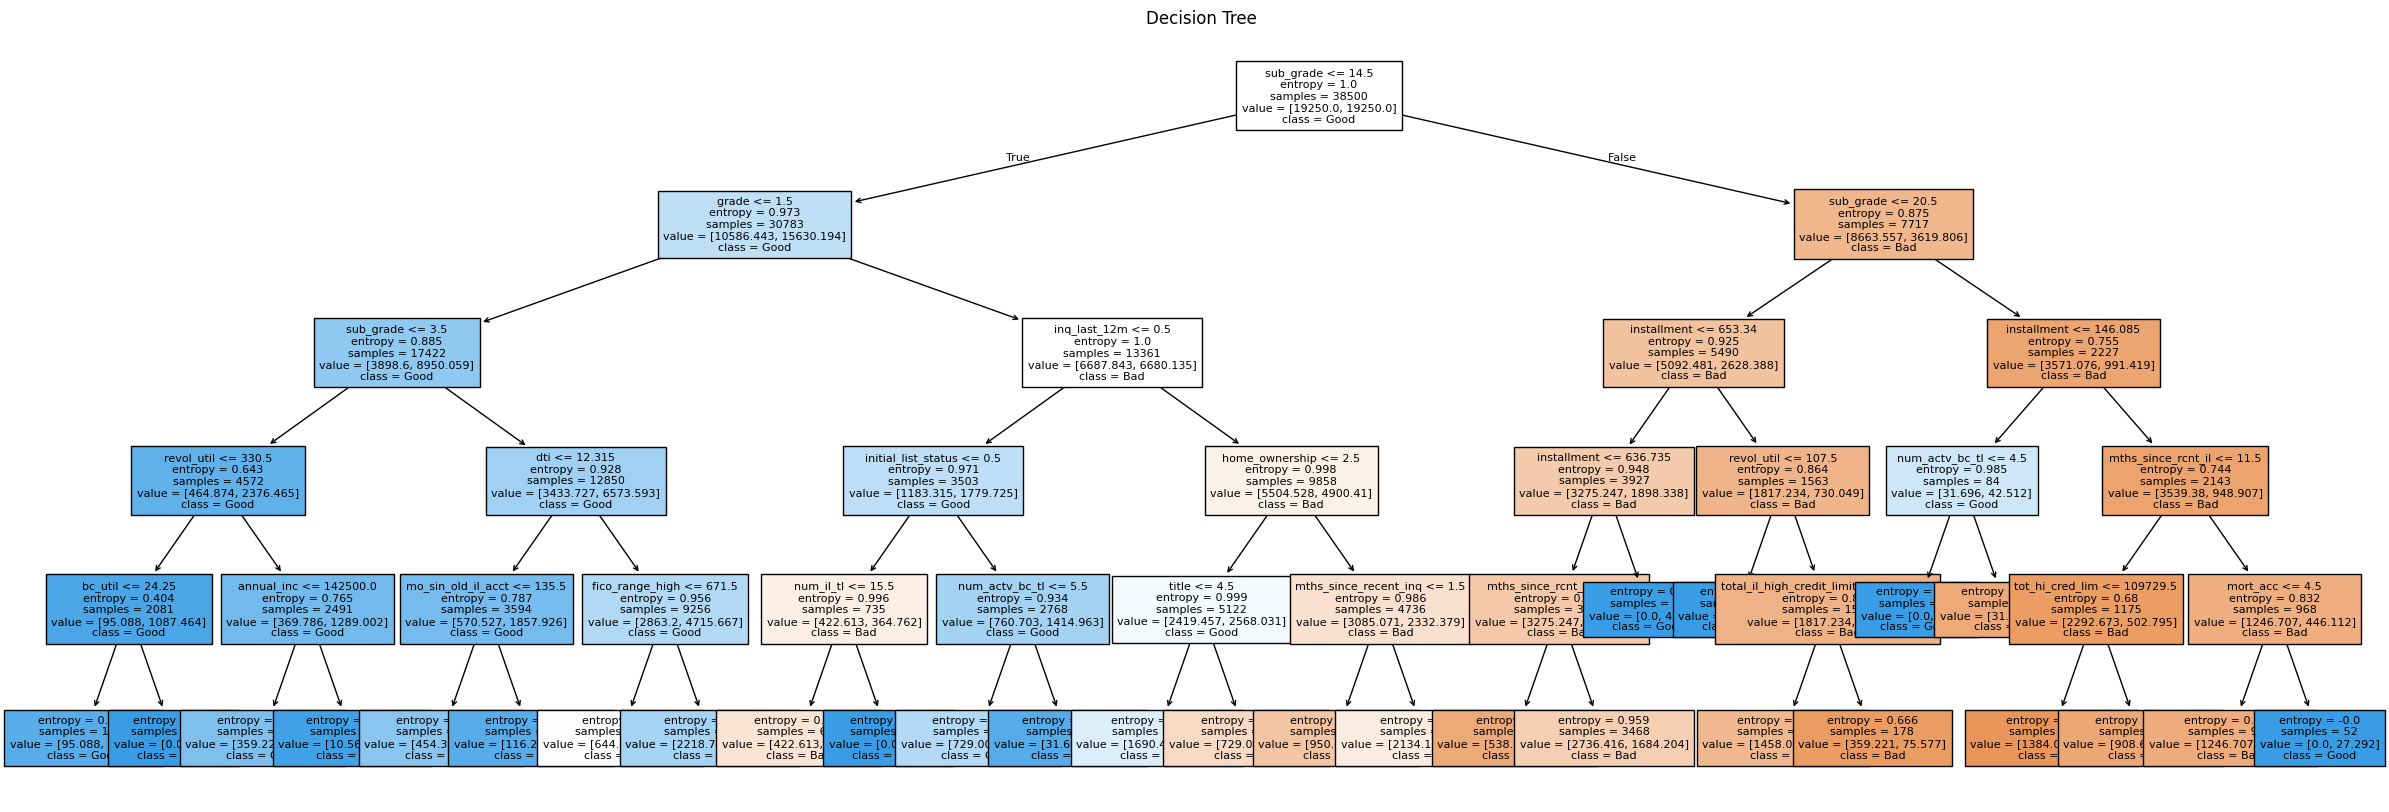

In [ ]:
#the figure of desecion tree
plt.figure(figsize=(30, 10))
plot_tree(dt,feature_names=X_train.columns,class_names=['Bad', 'Good'],filled=True,max_depth=5,fontsize=8)
plt.title("Decision Tree")
plt.show()

# RidgeClassifier Model

In [ ]:
# Create a pipeline: scale features, apply PCA, and train RidgeClassifier with balanced classes

steps =[("scaler", StandardScaler()), ("pca",PCA(n_components=0.95)), ("RidgeClassifier",RidgeClassifier(class_weight={1:1, 0:10}))]
pipeline = Pipeline(steps)

In [ ]:
# apply GridSearchCV to find the best alpha

param_grid = {"RidgeClassifier__alpha": [0.1, 1.0, 10.0, 100.0, 1000.0]}
Ridge_Classifier_cv = GridSearchCV(pipeline, param_grid , cv=5)

In [ ]:
# Train the RidgeClassifier

Ridge_Classifier_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('RidgeClassifier',
                                        RidgeClassifier(class_weight={0: 10,
                                                                      1: 1}))]),
             param_grid={'RidgeClassifier__alpha': [0.1, 1.0, 10.0, 100.0,
                                                    1000.0]})

In [ ]:
# Get the best trained model, make predictions

best_ridge_model = Ridge_Classifier_cv.best_estimator_
y_pred_Ridge = best_ridge_model.predict(X_test)
best_alpha = best_ridge_model.named_steps['RidgeClassifier'].alpha

# print best alpha and accuracy

print(f"Best alpha: {best_alpha}")
print(f"Ridge accuracy: {accuracy_score(y_test,y_pred_Ridge )}")

Best alpha: 1000.0
Ridge accuracy: 0.8771515151515151


<Figure size 900x700 with 0 Axes>

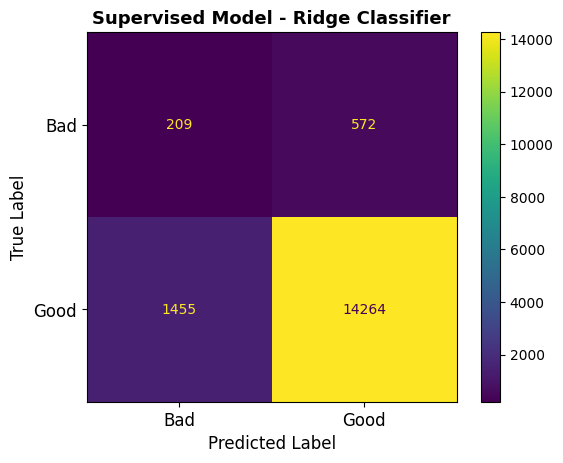

In [ ]:
# Plot the confusion matrix for RidgeClassifier predictions

plt.figure(figsize=(9,7))
cm_Ridge = confusion_matrix(y_test, y_pred_Ridge, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm_Ridge, display_labels=["Bad", "Good"])
disp.plot(cmap="viridis", values_format="d")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Supervised Model - Ridge Classifier" ,  fontsize=13, fontweight="bold")
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show()

#Data Before (K-Means) Model

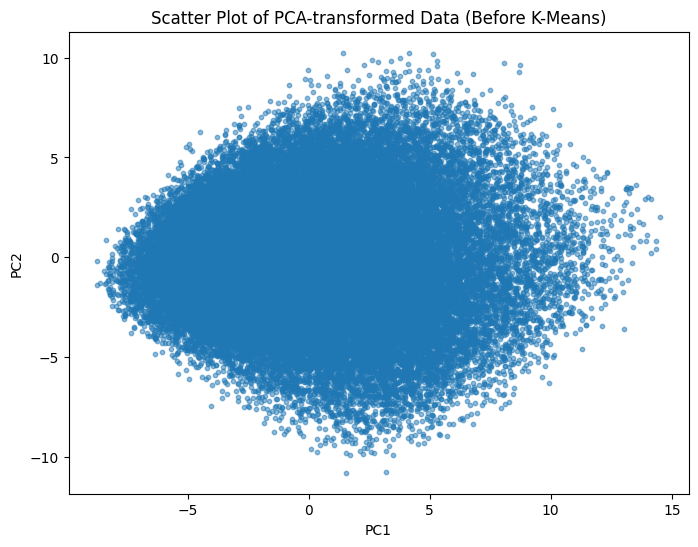

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], s=10, alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Scatter Plot of PCA-transformed Data (Before K-Means)")
plt.show()


**Elbow Method **For Determine Correct Nomber 'K'

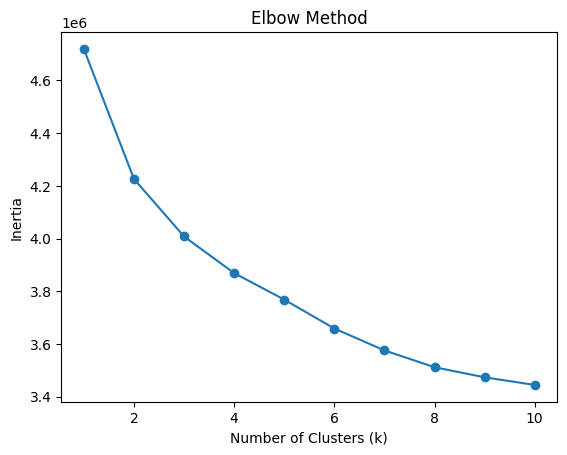

In [ ]:
SSE=[]
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df)
    SSE.append(kmeans.inertia_)

plt.plot(K, SSE, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

**Create K-MEans Model **

In [ ]:
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(pca_df)

pca_df["cluster"] = clusters
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,cluster
0,-3.997137,-0.105177,-0.808469,-1.072167,2.379308,2.125822,-1.398772,0.872091,1.288564,-0.155068,...,0.357765,0.427789,0.339036,0.246622,0.392861,0.187056,0.025304,0.402068,-0.277510,0
1,-3.461308,-1.310061,2.115290,0.119276,-0.945563,0.420031,2.521660,0.423772,0.648203,0.055748,...,-0.715854,-0.608321,0.479622,0.577441,-0.881604,1.265175,0.349281,-0.066398,0.923316,0
2,-4.427431,-2.562047,0.772256,-2.042383,-1.927233,-1.083821,-0.684659,3.260751,2.243950,-0.647523,...,-0.548594,-0.216037,-0.371100,0.328526,0.130950,0.215496,-0.341429,0.055963,0.789248,0
3,5.258648,3.049251,1.953582,2.030960,-2.013437,-0.419384,0.237038,-1.056570,-0.873428,0.156447,...,-0.623627,0.450266,-1.812954,0.669496,0.291466,-0.301984,-0.431522,-0.650942,0.412654,3
4,2.153381,-7.283549,-2.992275,-0.008852,1.362148,3.452965,-0.239501,1.778390,-0.772731,-0.314665,...,-0.984998,-0.234845,-0.358527,-0.053825,0.885916,-1.081645,1.109068,-0.528634,-0.676316,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,2.669400,-3.735874,0.532499,0.934207,-0.340281,1.712646,1.844535,0.984583,0.545677,-0.170351,...,0.838594,-0.550259,0.102111,0.648538,-0.029167,0.047099,0.628108,0.536831,-0.373449,2
54996,4.873963,-0.494632,-2.699401,1.858941,-1.793241,0.493941,0.860253,1.707683,1.665852,-0.163765,...,0.033730,1.257446,0.258159,0.501730,0.364308,0.329225,-0.843307,-0.455419,-0.675376,3
54997,-3.480472,-3.300084,-2.321198,0.466824,-2.337227,-4.761267,1.885440,0.307515,-0.957757,-0.071199,...,-0.360574,0.459112,-0.415980,0.504664,1.051951,-0.295808,0.207117,0.601170,-0.448903,0
54998,-3.049021,-1.683062,-0.861603,-0.194938,1.381615,0.947860,-1.341659,-2.846012,2.447700,0.584143,...,0.605154,-0.744060,0.232499,0.246200,0.585455,0.268209,0.788602,0.782211,-0.560797,0


(Cluster vs loan_good)

In [ ]:
pd.crosstab(df_sup["loan_good"], pca_df["cluster"])

cluster,0,1,2,3,4,5,6
loan_good,,,,,,,
0,329,99,211,137,150,185,204
1,7529,2554,4405,2996,3648,4275,4543


PCA Scatter Plot with Clusters

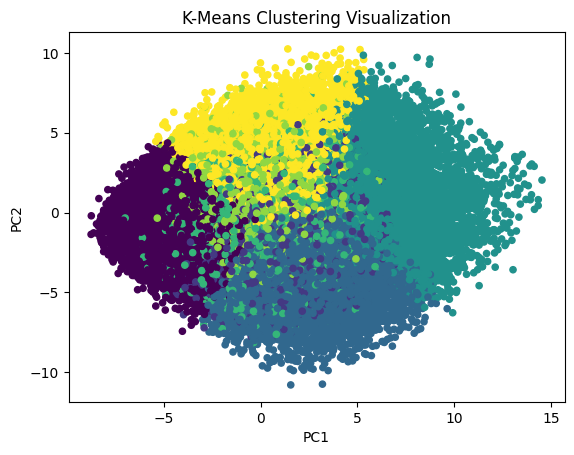

In [ ]:
plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df["cluster"], cmap='viridis', s=20)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clustering Visualization")
plt.show()


Silhouette Score

In [ ]:
score = silhouette_score(pca_df.drop("cluster", axis=1), pca_df["cluster"])
print("Silhouette Score:", score)

Silhouette Score: 0.06572766198786142


# results and evaluation

In [ ]:
#test shapes
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

X_train: (38500, 91)
X_test : (16500, 91)
y_train: (38500,)
y_test : (16500,)


In [ ]:
# function for evaluating each model
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

   #auc for roc curve
    auc = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test,y_proba)
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
        auc = roc_auc_score(y_test,y_proba)



    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "AUC":auc   }

In [ ]:
#apeend all results for models
results = []


#Random Forest
results.append(evaluate_model(model, X_train, y_train, X_test, y_test, "XGBClassifier"))
#decision tree
results.append(evaluate_model(dt, X_train, y_train, X_test, y_test, model_name="Decision Tree"))
#ridge classifier
results.append(evaluate_model(best_ridge_model, X_train, y_train, X_test, y_test, model_name="ridge classifier"))

results_df=pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1-score,AUC
0,XGBClassifier,0.882545,0.960318,0.914498,0.936848,0.692479
1,Decision Tree,0.649394,0.974312,0.649087,0.779123,0.692199
2,ridge classifier,0.877152,0.961445,0.907437,0.933661,0.714118


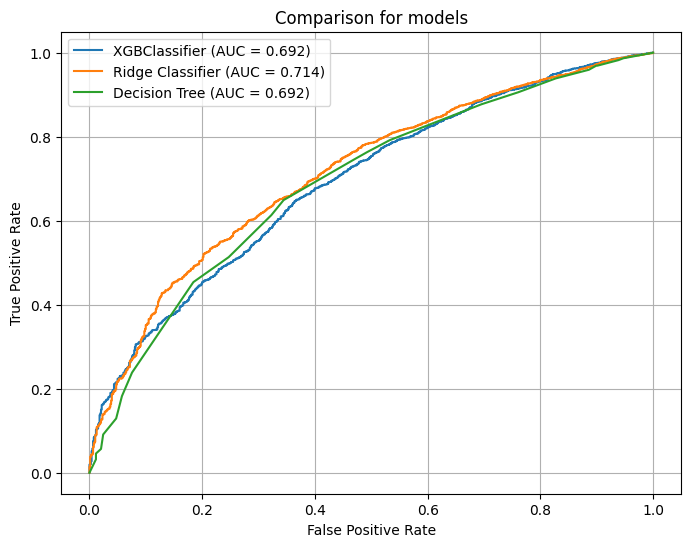

In [ ]:
#roc curve for models

# XGBClassifier
xg_proba = model.predict_proba(X_test)[:, 1]
xg_fpr, xg_tpr, _ = roc_curve(y_test, xg_proba)
xg_auc = auc(xg_fpr, xg_tpr)

# Ridge Classifier
y_proba_ridge=best_ridge_model.decision_function(X_test)
ridge_fpr, ridge_tpr, _ = roc_curve(y_test, y_proba_ridge)
ridge_auc = auc(ridge_fpr, ridge_tpr)

# Decision Tree
dt_proba = dt.predict_proba(X_test)[:, 1]
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_proba)
dt_auc = auc(dt_fpr, dt_tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(xg_fpr, xg_tpr, label=f"XGBClassifier (AUC = {xg_auc:.3f})")
plt.plot(ridge_fpr, ridge_tpr, label=f"Ridge Classifier (AUC = {ridge_auc:.3f})")
plt.plot(dt_fpr, dt_tpr, label=f"Decision Tree (AUC = {dt_auc:.3f})")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparison for models")
plt.legend()
plt.grid()
plt.show()